# DeepLabv3

## 학습목표
> 이번 실습에서는 U-Net과 다른 방식으로 segmentation을 수행하는 DeepLabv3을 직접 구현해보고, pre-trained DeepLabv3을 다운로드하여 PASCAL VOC 데이터셋으로 fine-tuning 하고 테스트하는 방법을 학습한다.


**목차(context)**
> 1. Deeplabv3 설명
> 2. DeepLabv3 모델 구현
> 3. VOC 데이터셋 다운로드
> 4. DeepLabv3 모델 학습
> 5. 학습된 DeepLabv3 모델 테스트

![img](https://images.velog.io/images/skhim520/post/a74d8ab4-c35d-4ab7-8d7a-5398e8a1b245/image.png)

## Deeplabv3 설명

> Deeplabv3는 다양한 object size가 들어오더라도 robust한 성능을 보이는 semantic segmentation model이다.
>
> 우선 Segmentation은 모든 픽셀에 대해 classification을 해야하기 때문에, 픽셀의 위치 정보가 중요하다고 생각할 수 있다.
> 하지만 UNet의 encoder-decoder 구조는 encoding을 통해 이미지의 위치 정보를 많이 잃게 만든다.
> 따라서 Deeplab v3는 Encoder-Decoder 구조가 아닌 spatial dimension의 크기를 유지하며 segmentation을 진행하도록 모델을 설계하였다.
>
> 또한 Segmentation을 해야하는 물체의 크기가 이미지에서 많은 부분을 차지한다면, convolution layer의 receptive field 또한 거기에 맞게 커져야 한다.
> 하지만 receptive field를 단순히 크게 만들기에는 parameter의 수를 늘리게 되기 때문에 연산량에서 효율성을 떨어뜨린다.
> 이를 해결하기 위해 넓은 receptive field를 활용하면서도 효율적인 연산을 할 수 있는 Atrous convolution을 사용한다.
>
> 마지막으로 한번에 다양한 스케일의 receptive field를 처리하기 위해 Atrous Spatial Pyramid Pooling (ASPP) 구조를 사용하여 multi-scale feature를 효과적으로 활용한다.

### 모델 구조

>Atrous convolution:
> Atrous convolution은 convolution layer에서 parameter 수는 그대로 유지하면서 receptive field 크기를 넓히기 위해 고안된 방식이다. \
> Windows size를 늘릴 때 filter의 파라미터와 파라미터 사이에 빈 값을 넣어서 receptive field를 늘리는 방식이다.\
> 즉 아래의 그림처럼 파라미터의 수는 고정되어 있으면서 window size만 커지는 것이기 때문에, 연산량의 증가 없이 receptive field를 늘릴 수 있는 효과가 생긴다. \
> 이때 rate는 픽셀간의 간격을 의미하는데, rate가 1일 때는 우리가 원래 사용하는 CNN filter이다.\
> 결론적으로, Atrous convloution을 사용하면 넓은 범위 receptive field를 효율적으로 사용할 수 있게 된다.

**Atrous convolution**

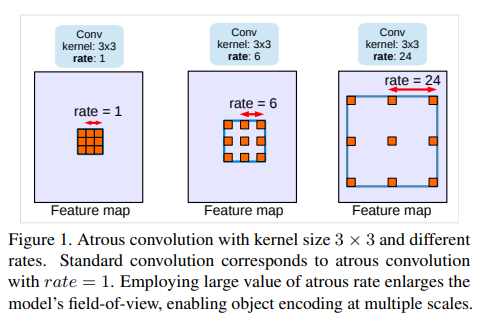

> 아래 Figure 3의 (a)와 같이 U-Net의 encoder는 feature map의 resoultion을 축소시키는 구조이다.
> 따라서 데이터의 spatial 정보를 잃을 수 밖에 없게 되고, 이는 Pixel-wise classification을 해야 하는 segmenatation task에서 비효율 적이라고 이해할 수 있다. \
> DeepLab V3는 점점 더 rate가 커지도록 구성된 Atrous Convolution layer를 통해 큰 receptive field를 효과적으로 사용할 뿐만 아니라, 필터 사이즈에 맞는 stride를 사용하여 layer가 많아져도 feature map의 크기가 축소되지 않게 모델을 구성한다.\
> 이렇게하면 model의 depth가 늘어나도 resolution은 유지하면서 다양한 범위의 feature를 사용할 수 있게 되며, parameter 수 또한 늘어나지 않게 된다는 장점이 생긴다.
> 아래 제안된 모델을 DeepLab V3의 cascade 버전이라고 부른다.

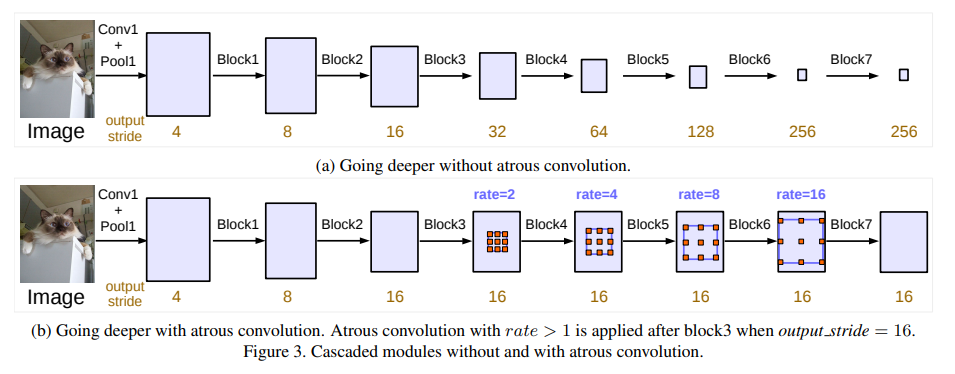

**ASPP (Atrous Spatial Pyramid Pooling)**
> DeepLab V3의 또 다른 버전인 parallel 버전은 ASPP를 사용한다.
> ASPP는 병렬적으로 rate가 다른 여러 dilated convolution 연산을 한번에 수행한다. \
> 이때 rate가 커질수록 zero-padded 영역이 아닌 실제 feature map에서의 연산하는 횟수가 줄어든다는 것을 알 수 있다.
> 즉 특정 영역에 치우쳐 feature가 만들어질 수 있고 이는 이미지의 global한 정보가 부족한 feature일 것이다.
> 이것을 해결하기 위해서 ASPP 모듈의 인풋으로 사용되는 feature를 channel-wise로 average pooling을 하여 1x1 feature map을 만든다. \
> 이 feature map은 image의 global한 feature를 담고 있을 것이라고 생각할 수 있다.
> 마지막으로, Atrous convolution의 결과로 만들어진 feature들과 pooling으로 만들어진 feature를 concat 후 1x1 convolution 연산을 하여 최종 output feature를 만들게 된다. \
> 이때 pooling으로 만들어진 feature를 concat 하기 위해 ASPP 연산 결과로 나온 feature의 size로 크기를 키워줘야 하는데, bilinear interpolation 방식으로 size를 같게 해준다.

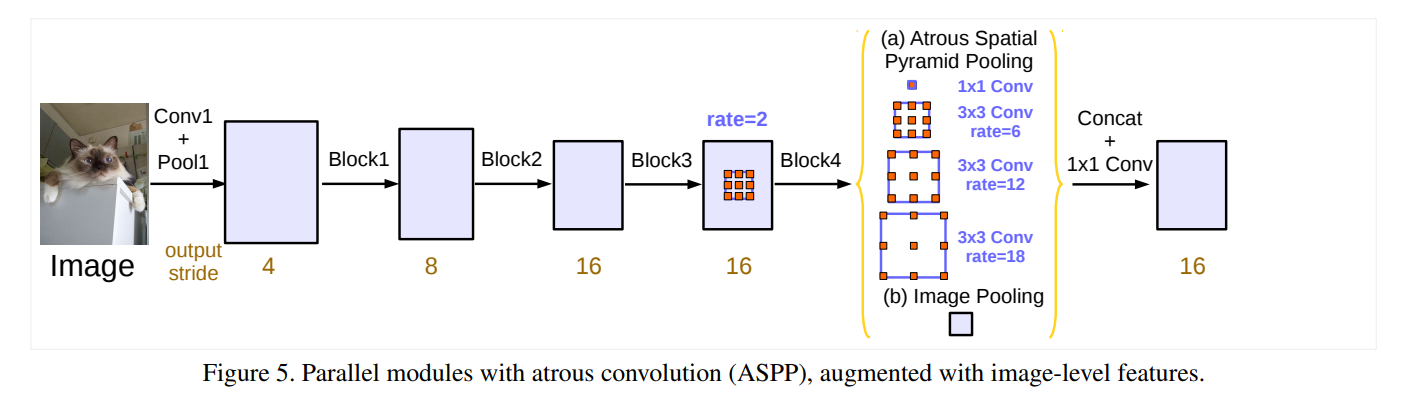

## DeepLabv3 모델 구현

> 앞에서 정의한 ASPP를 이용하여 DeepLab v3를 구현한다.\
> 우선 DeepLabv3 모델의 backbone은 성능 상의 이점을 위해 ImageNet으로 사전학습된 ResNet101을 사용한다.\
> ResNet101을 사용하여 feature를 뽑은 후, segmentation을 위한 최종 classification을 위하여 DeepLabHead를 이용한다.\
> DeepLabHead는 (ASPP, Conv, BN, ReLU, Conv)로 구현된 블럭으로 생각할 수 있다.

In [1]:
import torch
import os
import albumentations as A
import numpy as np

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt

from torch import nn
import torch.optim as optim

from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.transforms.functional import to_tensor
from torchvision.utils import save_image

> 우선 모델의 구성 요서 중 하나인 ASPPConv class를 구현한다. \
> 필터 사이즈는 3x3이고 padding size는 dilation 비율과 같도록 conv를 설계한다. \
> ASPPConv는 (Atrous convolution, Batch normalization, ReLU)로 구성된 블럭이다.

In [2]:
class ASPPConv(nn.Sequential):
    # (AtrousConv, BN, ReLU)로 구성
    def __init__(self, in_channels, out_channels, dilation):
        super(ASPPConv, self).__init__()
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation,
                      dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()]
        self.layers = nn.Sequential(*modules)

    def forward(self, x):
        return self.layers(x)

> ASPPConv 구현의 검증을 목적으로, 더미 데이터를 만들어서 연산을 수행해 본다.
>
> dilated conv의 rate을 조절할 때는 아래와 같이 dilation 인자의 값을 바꿔주면 된다.

In [3]:
conv = ASPPConv(16, 8, dilation=3)
dummy_x = torch.randn([3, 16, 64, 64])
dummy_pred = conv(dummy_x)
print(dummy_pred.shape)

conv = ASPPConv(16, 8, dilation=6)
dummy_x = torch.randn([3, 16, 64, 64])
dummy_pred = conv(dummy_x)
print(dummy_pred.shape)

torch.Size([3, 8, 64, 64])
torch.Size([3, 8, 64, 64])


> ASPPConv class를 사용해 ASPPPooling을 구현한다.
>
> 각 H * W 크기의 채널 별로 average 연산을 수행한 뒤 1x1 conv를 통해서 out_channel 을 조절한다. 마지막으로 batch normalization과 ReLU 연산을 수행한다.
>
> 이때 앞의 설명과 같이 average pooling으로 사이즈가 1x1이 된 feature map의 사이즈를 ASPPConv의 output과 같게 만들어 줘야 하기 때문에 interpolate 함수를 사용한다.
>
> 여기서 AdaptiveAvgPool2d 함수를 사용하는데, 이 pooling 함수는 기존의 함수와는 달리 pooling을 적용한 후 output feature의 size를 함수의 인자로 준다.
> 그랬을 때 이 함수를 적용하면 output의 feature shape이 지정한 인자로 반환되게 된다.
> 그 사용법은 아래와 같다.

In [4]:
m = nn.AdaptiveAvgPool2d(output_size=(5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
output.shape

torch.Size([1, 64, 5, 7])

In [5]:
class ASPPPooling(nn.Sequential):
    # 1x1 feature map 만들기
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),  # H*W 의 average 값을 출력
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

> ASPPPooling 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [6]:
conv = ASPPPooling(16, 8)
dummy_x = torch.randn([3, 16, 64, 64])
dummy_pred = conv(dummy_x)
print(dummy_pred.shape)

torch.Size([3, 8, 64, 64])


> ASPP 모듈을 구현한다. \
> project layer는 결과물을 concat 한 뒤 output_channels로 바꿔준다. 이때, filter는 1x1를 이용한다.

In [7]:
class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))
        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels,
                      out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

> ASPP 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [8]:
conv = ASPP(16, atrous_rates = [12, 24, 36])
dummy_x = torch.randn([3,16,64,64])
dummy_pred = conv(dummy_x)
print(dummy_pred.shape)

torch.Size([3, 256, 64, 64])


> DeepLabHead을 구현한다.

In [10]:
class DeepLabHead(nn.Sequential):
    # (ASPP + (Conv,BN,ReLU) + Conv)로 구성
    def __init__(self, in_channels, num_classes):
        super(DeepLabHead, self).__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )

> 앞서 구현한 모듈들을 종합하여, DeepLabV3 전체 모델을 구현한다.

In [11]:
class DeepLabV3(nn.Module):

    def __init__(self, backbone, classifier, aux_classifier=None):
        super(DeepLabV3, self).__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)

        result = OrderedDict()
        x = features["out"] # backbone을 가져오는 방식 중 하나, 다른 방식도 가능
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        result["out"] = x

        return result

## VOC 데이터셋 소개
> PASCAL VOC 데이터셋은 Image recognition과 관련된 테스크인 classification, detection, segmentation 등에서 모델간의 성능 비교를 하는 대회를 위해 만들어진 데이터셋이다.\
> 그 중 segmentation과 관련된 데이터셋은 총 20개의 class로 이루어져 있으며 그 종류는 다음과 같다.
> - Person: person
> - Animal: bird, cat, cow, dog, horse, sheep
> - Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
> - Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor
>
> 각 class 별 예시 그림은 아래 그림과 같으며, segmentation task를 진행할 때는 배경도 하나의 class로 포함하여 총 21개의 class를 사용한다. \
> 즉, 우리는 VOC 데이터셋을 이용해 각 pixel 마다 21개의 class 중 하나로 분류하는 task를 수행한다.

![voc](https://drive.google.com/uc?export=download&id=18mfU-4COxtAmhgVzXdYhbkb5vsqH6xM2)

> VOC 데이터셋은 segmentation task의 학습을 위해 아래 그림과 같이 segmentation용 label을 제공한다.

![voc](https://drive.google.com/uc?export=download&id=1WGKRYUyaWx8g8A4ToSMG4p6szouVqSzN)

## VOC 데이터셋 다운로드


> Pascal voc 2007 데이터셋을 다운로드한다.

In [12]:
from torchvision.datasets import VOCSegmentation
VOCSegmentation(root='./data', year='2007', download=True)

100%|██████████| 460032000/460032000 [00:17<00:00, 26040237.60it/s]


Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: ./data

## DeepLabV3 모델 학습
> 데이터셋 class를 정의한다.

In [13]:
class DatasetFromFolderVOC(Dataset):
    def __init__(self, root_dir= './data/VOCdevkit/VOC2007', txt_file='train.txt', transforms=None):
        super(DatasetFromFolderVOC, self).__init__()
        with open(os.path.join(root_dir, 'ImageSets/Segmentation', txt_file), 'r') as f:
            self.filenames = f.readlines()
        self.filenames = [file.strip() for file in self.filenames]
        self.img_path = os.path.join(root_dir, "JPEGImages")
        self.gt_path = os.path.join(root_dir, "SegmentationClass")
        self.transforms = transforms
        self.pallete = Image.open(os.path.join(self.gt_path, f'{self.filenames[0]}.png')).getpalette()

    # getitem 함수는 index에 맞는 data를 반환하는 역할
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, f'{self.filenames[index]}.jpg')).convert('RGB')
        gt = Image.open(os.path.join(self.gt_path, f'{self.filenames[index]}.png'))

        aug = self.transforms(image=np.array(img), mask=np.array(gt))
        img = to_tensor(aug['image'])
        gt = aug['mask']
        gt[gt > 20] = 0
        gt = torch.tensor(gt)

        return img, gt

    # len 함수는 Dataset 전체 개수를 반환
    def __len__(self):
        return len(self.filenames)

> 정의된 데이터셋 class를 불러와서 확인한다.

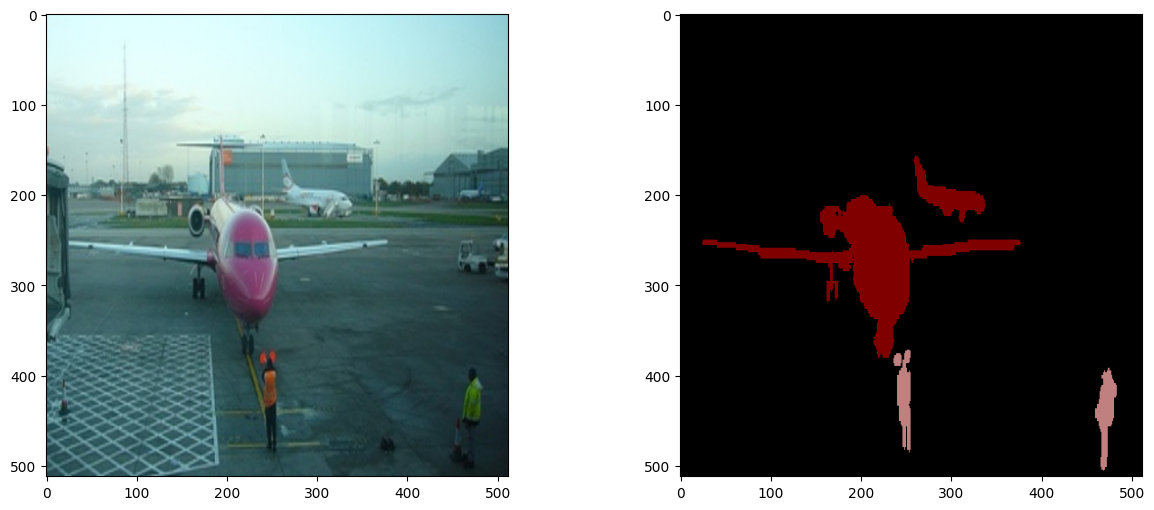

In [14]:
transforms = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(400, 400),
    A.HorizontalFlip(always_apply=True),
    # A.VerticalFlip(always_apply=True),
    A.Resize(512, 512),
])

dataset = DatasetFromFolderVOC(transforms=transforms)
img, gt = dataset[0]
pallete = dataset.pallete

gt_img = Image.fromarray(np.array(gt))
gt_img.putpalette(dataset.pallete)

# Augmentation이 적용된 이미지와 레이블 시각화
plt.rcParams["figure.figsize"] = (15, 6)
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(gt_img)

> 데이터셋 및 데이터로더를 정의한다.

In [41]:
transforms = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(200, 200),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(256, 256),
])

trainDataSet = DatasetFromFolderVOC(txt_file='train.txt', transforms=transforms)
testDataSet = DatasetFromFolderVOC(txt_file='val.txt', transforms=transforms)

trainDataLoader = DataLoader(dataset=trainDataSet, num_workers=1, batch_size=8, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataSet, num_workers=1, batch_size=1, shuffle=False, drop_last=True)

> DeepLabv3 모델을 정의한다.

In [16]:
import torchvision

# Resnet 101의 layer4 output과 DeepLabHead를 연결
resnet101 = torchvision.models.resnet101(pretrained=True, replace_stride_with_dilation=[False, True, True])
return_layers = {'layer4': 'out'}
backbone = torchvision.models._utils.IntermediateLayerGetter(resnet101, return_layers)

num_classes = 21  # 20 + background
classifier = DeepLabHead(2048, num_classes)

model = DeepLabV3(backbone=backbone, classifier=classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 60.5MB/s]


> Pre-trained weight를 불러온다.

In [17]:
model.load_state_dict(torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).state_dict(), strict=False)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 173MB/s]


> 불러온 모델이 잘 작동하는지 test data를 활용하여 확인한다.

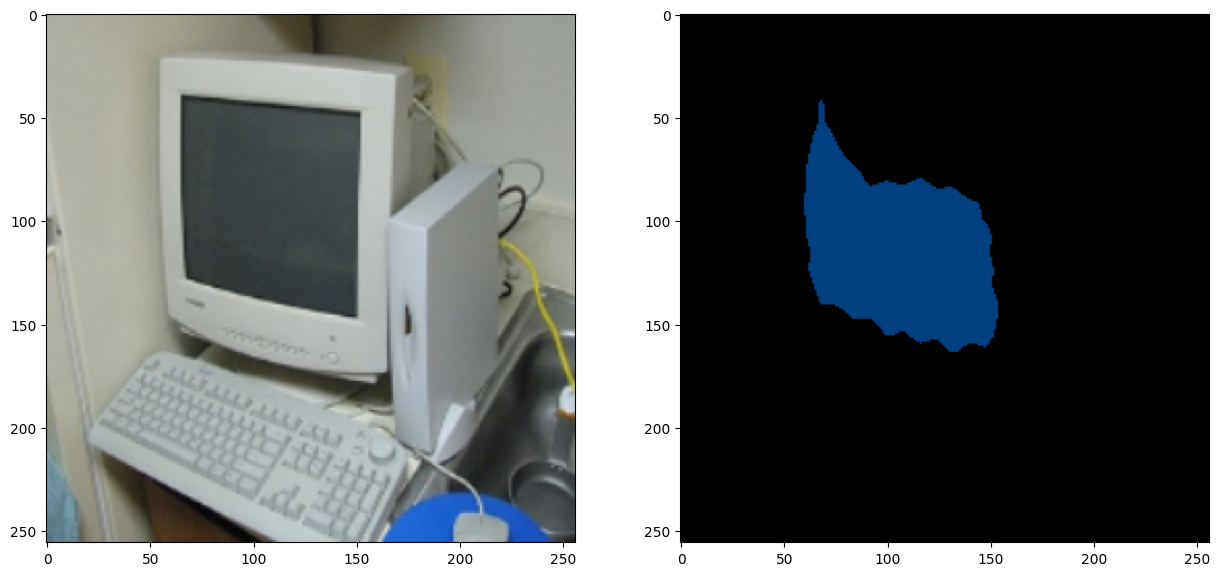

In [18]:
model.eval()
num_imgs = 1

for i, (img, gt) in enumerate(testDataLoader):
    with torch.no_grad():
        img = img.cuda()
        gt = gt.long().cuda()

        pred = model(img)['out']
        output_pred = pred.argmax(1)

        for j in range(num_imgs):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(testDataSet.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)

            preds_test = out_img
            gt_img = img
        break

test_samples = preds_test
test_samples = torchvision.utils.make_grid(test_samples, nrow=1)
test_samples = test_samples.permute(1, 2, 0)

plt.rcParams["figure.figsize"] = (15, 15)
plt.subplot(1, 2, 1)
plt.imshow(gt_img[0].cpu().permute(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(test_samples)

> Optimizer, model, loss function을 정의한다.

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-6, betas=(0.9, 0.999))
model = model.cuda()
criterion = nn.CrossEntropyLoss()

> 학습에 앞서 세가지의 유용한 함수를 선언해준다.\
> 학습 중간에 loss의 값이 어떻게 변하는지를 시각화 해주는 loss_plot함수를 구현한다.

In [20]:
def loss_plot(loss):
    plt.plot(loss)
    plt.xlabel('log')
    plt.ylabel('loss')
    plt.grid(True)
    plt.show()
    return 0

> 학습이 시작한 후 시간이 얼마나 흘렀는지를 확인할 수 있는 Timer 클래스를 구현한다.

In [21]:
import time
class Timer():
    def __init__(self):
        self.cur_t = time.time()

    def tic(self):
        self.cur_t = time.time()

    def toc(self):
        return time.time() - self.cur_t

    def tocStr(self, t=-1):
        if (t == -1):
            return str(datetime.timedelta(seconds=np.round(time.time() - self.cur_t, 3)))[:-4]
        else:
            return str(datetime.timedelta(seconds=np.round(t, 3)))[:-4]

> 테스트 데이터로 모델의 일반화 성능을 측정하기 위한 함수를 구현한다.

In [22]:
def test_seg(model, loss_list):
    model.eval()
    running_loss = 0.0
    for i, (img, gt) in enumerate(testDataLoader):
        with torch.no_grad():
            # forward
            img = img.cuda()
            gt = gt.long().cuda()
            pred = model(img)['out']
            loss = criterion(pred, gt)
            running_loss += loss
    print(f'Current test loss: {running_loss.item()/(i+1):.3f}')
    loss_list.append(running_loss.item()/(i+1))
    return loss_list

> 모델 학습을 시작한다.

In [23]:
tell_time = Timer()
iter_time = 0

model = model.train()
total_epoch = 50

loss_list = []
for epoch in range(total_epoch):
    for i, (img, gt) in enumerate(trainDataLoader):
        img = img.cuda()
        gt = gt.long().cuda()

        pred = model(img)['out']

        loss = criterion(pred, gt)

        # Backprop + Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1)%10 == 0:
            print(f'[Epoch {epoch+1}] [Iter {i+1}/{len(trainDataLoader)}] Train loss: {loss.item():.3f} iter_time: {tell_time.toc()-iter_time}')
            loss_list = test_seg(model, loss_list)
            iter_time = tell_time.toc()

loss_plot(loss_list)

[Epoch 1] [Iter 10/26] Train loss: 1.522 iter_time: 9.310149669647217
Current test loss: 1.586
[Epoch 1] [Iter 20/26] Train loss: 0.777 iter_time: 8.30966329574585
Current test loss: 1.098
[Epoch 2] [Iter 10/26] Train loss: 0.330 iter_time: 13.681356191635132
Current test loss: 0.799
[Epoch 2] [Iter 20/26] Train loss: 0.684 iter_time: 8.837001085281372
Current test loss: 0.731
[Epoch 3] [Iter 10/26] Train loss: 0.728 iter_time: 14.578282833099365
Current test loss: 0.653
[Epoch 3] [Iter 20/26] Train loss: 0.773 iter_time: 9.42534875869751
Current test loss: 0.650
[Epoch 4] [Iter 10/26] Train loss: 0.388 iter_time: 14.80324387550354
Current test loss: 0.635
[Epoch 4] [Iter 20/26] Train loss: 0.399 iter_time: 9.107595205307007
Current test loss: 0.579
[Epoch 5] [Iter 10/26] Train loss: 0.544 iter_time: 14.547576665878296
Current test loss: 0.609
[Epoch 5] [Iter 20/26] Train loss: 0.465 iter_time: 9.157789707183838
Current test loss: 0.573
[Epoch 6] [Iter 10/26] Train loss: 0.565 iter_tim

KeyboardInterrupt: 

> 테스트 데이터를 이용해 학습된 모델을 평가한다.

In [24]:
model.eval()
running_loss = 0.0
for i, (img, gt) in enumerate(testDataLoader):
    with torch.no_grad():
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)['out']
        loss = criterion(pred, gt)
        running_loss += loss


print(f'[{i+1}/{len(testDataLoader)}] Loss: {running_loss.item()/(i+1):.3f}')

[213/213] Loss: 0.519


> 이때 정량적 평가 뿐만 아니라, 정성적 평가를 함께 하기 위해 결과를 시각화한다.\
> 정성적 결과를 봤을 때에도 모니터를 잘 예측하고 있는 모습을 확인할 수 있다.

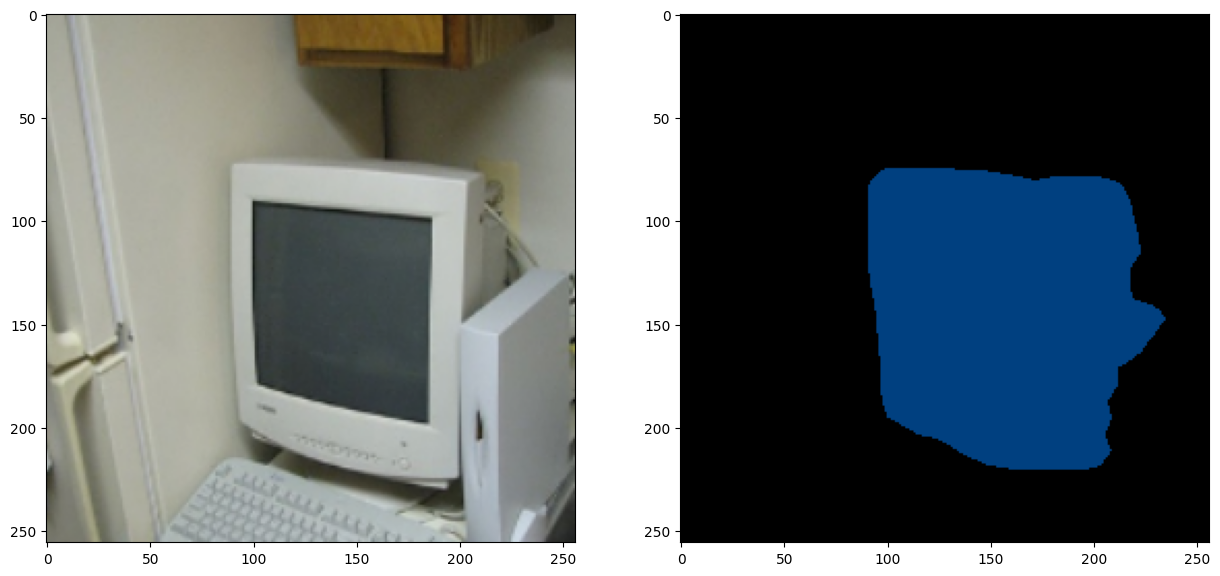

In [25]:
model.eval()
num_imgs = 1

for i, (img, gt) in enumerate(testDataLoader):
    with torch.no_grad():
        img = img.cuda()
        gt = gt.long().cuda()

        pred = model(img)['out']
        output_pred = pred.argmax(1)

        for j in range(num_imgs):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(testDataSet.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)

            preds_test = out_img
            gt_img = img
        break

test_samples = preds_test
test_samples = torchvision.utils.make_grid(test_samples, nrow=1)
test_samples = test_samples.permute(1, 2, 0)

plt.rcParams["figure.figsize"] = (15, 15)
plt.subplot(1, 2, 1)
plt.imshow(gt_img[0].cpu().permute(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(test_samples)